#### [ LSTM 구조 ]  
: LSTM에는 순환되는 상태가 2개 (은닉 상태 말고 셀 상태라고 부르는 값이 존재)  
: 은닉 상태와 달리 셀 상태는 다음 층으로 전달되지 않고 현재 셀 안에서만 순환되는 값  
: 입력과 은닉 상태에 곱해지는 가중치 wo 와 wi가 다르다  
: `삭제`, `입력`, `출력`게이트가 존재한다

#### [ LSTM 신경망 훈련하기 ]

In [9]:
from keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target,  val_target = train_test_split(train_input, train_target, test_size = 0.2, random_state=42)

그다음 케라스의 pad_sequences() 함수로 각 샘플의 길이를 100에 맞추고 부족할 때는 패딩을 추가

In [10]:
from keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

LSTM 셀을 사용한 순환층 만들기 (SimpleRNN 클래스를 LSTM 클래스로 변경만 하면 됨)

In [11]:
import keras
model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Input(shape=(100,)))
model_lstm.add(keras.layers.Embedding(500, 16))
model_lstm.add(keras.layers.LSTM(8))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))

In [12]:
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

lstm 에는 셀 4개가 존재 ==> SimpleRNN의 파라미터의 개수 200개 보다 4배인 800개가 존재

In [13]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model_lstm.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5943 - loss: 0.6579 - val_accuracy: 0.7414 - val_loss: 0.5269
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7656 - loss: 0.5039 - val_accuracy: 0.7806 - val_loss: 0.4710
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.7844 - loss: 0.4620 - val_accuracy: 0.7802 - val_loss: 0.4664
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8015 - loss: 0.4360 - val_accuracy: 0.8016 - val_loss: 0.4369
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8111 - loss: 0.4198 - val_accuracy: 0.7940 - val_loss: 0.4381
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8097 - loss: 0.4140 - val_accuracy: 0.8018 - val_loss: 0.4338
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8149 - loss: 0.4040 - val_accuracy: 0.7802 - val_loss: 0.4528
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8147 - loss: 0.4024 - 

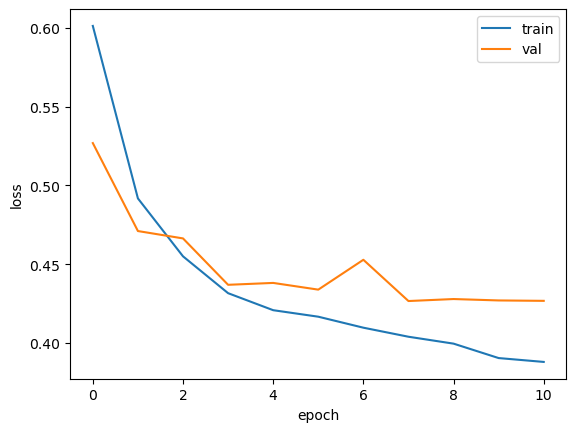

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

훈련 손실이 잘 줄어들고 있지만 과대적합을 잘 억제하지 못한 것 같음

#### [ 순환층에 드롭아웃 적용하기 ]

In [15]:
model_dropout = keras.Sequential()
model_dropout.add(keras.layers.Input(shape=(100,)))
model_dropout.add(keras.layers.Embedding(500, 16))
model_dropout.add(keras.layers.LSTM(8, dropout=0.2))
model_dropout.add(keras.layers.Dense(1, activation='sigmoid'))

In [16]:
model_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-droput-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model_dropout.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5940 - loss: 0.6581 - val_accuracy: 0.7662 - val_loss: 0.5025
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7803 - loss: 0.4802 - val_accuracy: 0.7868 - val_loss: 0.4659
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7868 - loss: 0.4546 - val_accuracy: 0.8028 - val_loss: 0.4387
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8066 - loss: 0.4218 - val_accuracy: 0.8016 - val_loss: 0.4335
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.8073 - loss: 0.4241 - val_accuracy: 0.7978 - val_loss: 0.4311
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8095 - loss: 0.4153 - val_accuracy: 0.7744 - val_loss: 0.4546
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8130 - loss: 0.4146 - val_accuracy: 0.7948 - val_loss: 0.4440
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8120 - loss: 0.4064 -

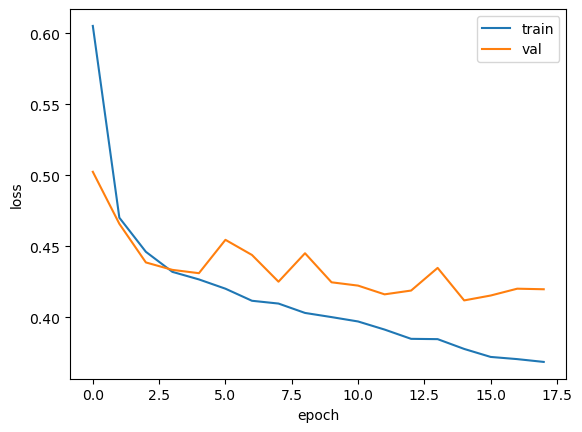

In [17]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

#### [ 2개의 층을 연결하기 ]  
: 케라스의 순환층에서 모든 타입랩스의 은닉 상태를 출력하려면 마지막을 제외한 다른 모든 순환층에서 return_sequences 매개변수를 True로 지정하면 된다.

In [18]:
model_2lstm = keras.Sequential()
model_2lstm.add(keras.layers.Input(shape=(100,)))
model_2lstm.add(keras.layers.Embedding(500, 16))
model_2lstm.add(keras.layers.LSTM(8, dropout=0.2, return_sequences=True))
model_2lstm.add(keras.layers.LSTM(8, dropout=0.2,))
model_2lstm.add(keras.layers.Dense(1, activation='sigmoid'))
model_2lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 8)         │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

첫 번째 LSTM 층이 모든 타임스텝(100개)의 은닉 상태를 출력하기 때문에 출력 크기가(None, 100, 8)로 표시  
두 번째 LSTM 층의 출력 크기는 마지막 타임스텝의 은닉 상태만 출력하기 때문에 (None, 8)이다

In [19]:
model_2lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2lstm-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model_2lstm.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.5909 - loss: 0.6507 - val_accuracy: 0.7250 - val_loss: 0.5429
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.7728 - loss: 0.4842 - val_accuracy: 0.7400 - val_loss: 0.5278
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.7910 - loss: 0.4571 - val_accuracy: 0.8016 - val_loss: 0.4360
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.8069 - loss: 0.4295 - val_accuracy: 0.8058 - val_loss: 0.4265
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8111 - loss: 0.4210 - val_accuracy: 0.8120 - val_loss: 0.4209
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.8146 - loss: 0.4154 - val_accuracy: 0.8090 - val_loss: 0.4216
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.8122 - loss: 0.4173 - val_accuracy: 0.8000 - val_loss: 0.4372
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.8188 - loss: 0

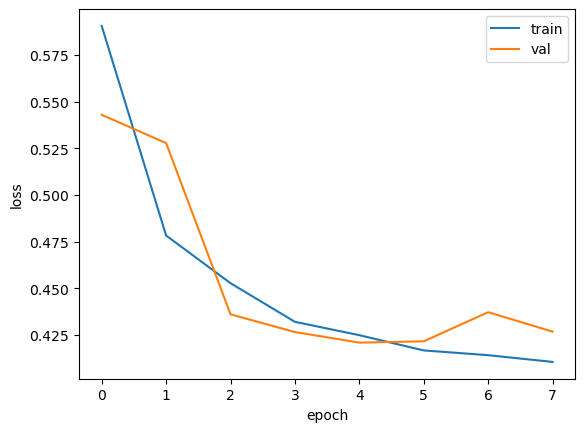

In [20]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

#### [ GRU 구조 ]  
: GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀이 3개 들어있다.  
: 2개는 시그모이드 함수를 하나는 tanh 활성화 함수를 사용한다

In [21]:
import keras
model_gru = keras.Sequential()
model_gru.add(keras.layers.Input(shape=(100,)))
model_gru.add(keras.layers.Embedding(500, 16))
model_gru.add(keras.layers.GRU(8, dropout=0.2,))
model_gru.add(keras.layers.Dense(1, activation='sigmoid'))
model_gru.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model_gru.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.5630 - loss: 0.6763 - val_accuracy: 0.7534 - val_loss: 0.5269
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7567 - loss: 0.5034 - val_accuracy: 0.7674 - val_loss: 0.4838
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7830 - loss: 0.4701 - val_accuracy: 0.7806 - val_loss: 0.4695
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7978 - loss: 0.4446 - val_accuracy: 0.7896 - val_loss: 0.4579
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8003 - loss: 0.4354 - val_accuracy: 0.7994 - val_loss: 0.4349
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8055 - loss: 0.4301 - val_accuracy: 0.7964 - val_loss: 0.4375
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8074 - loss: 0.4251 - val_accuracy: 0.8030 - val_loss: 0.4357
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8172 - loss: 0

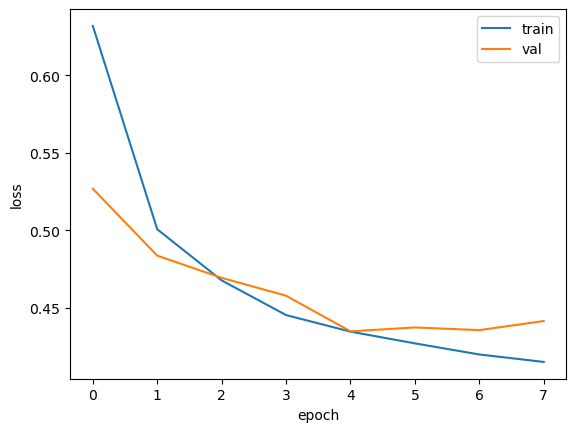

In [23]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

#### [ LSTM과 GRU 셀로 훈련 ]

In [24]:
test_seq = pad_sequences(test_input, maxlen=100)
best_model = keras.models.load_model('best-gru-model.keras')
best_model.evaluate(test_seq, test_target)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8011 - loss: 0.4335


[0.43305182456970215, 0.7994800209999084]